In [1]:
import pandas as pd
import os
os.chdir('..')
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from xgboost import XGBRegressor
from utils import *

import wandb
from wandb.xgboost import WandbCallback
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

In [28]:
df_first = pd.read_csv(r'data\cleaned_data\5_household\power\SFH4_demand_W.csv', index_col=0, parse_dates=True)

#df_first = pd.read_csv(r"C:\Users\nik\iCloudDrive\PhD_Icloud\PhD_Papers\Berkeley\Data\load_data_15min_watts.csv", index_col=0, parse_dates=True).iloc[:,-1:]


# Data cleaning
#-----------------------#
df = remove_duplicate_index(df_first)

df = remove_days(df, 0.2)

df[df<=0] = 1e-6 # because of log transform

df_clean = df.copy()

In [29]:
px.line(df_clean)

## Wandb

### Testing

In [30]:
config_features = {
    'holidays': True,
    'holidays_country': 'AT',
    'peaks': True,
    'boxcox': True,
    'lam': None,
    'cumsum': True,
    'lagged_days': 0,
    'datetime': True,
    }

model_params = { 
                'tree_method': 'gpu_hist', 
                'predictor': 'gpu_predictor',
                'objective': 'reg:pseudohubererror',
                'colsample_bytree': 0.9,
                'subsample': 0.7,
                'num_boost_round': 30,
                'learning_rate': 0.01, 
                'max_depth': 3,
                'n_estimators': 300,
                'min_child_weight': 5,
                'reg_alpha': 0.01, 
                'reg_lambda': 0.1, 
                'gamma': 0,
                'eval_metric': dtw_scorer,
                #'early_stopping_rounds': 3,
    }


#plotting parameters
rows_to_plot = 4 # min 1
outputs_per_row = 4

### Lets train with wandb

In [31]:
def lets_train():
    wandb.init(
        project="XGBoost",
        )

    wandb.config.update(config_features)
    wandb.config.update(model_params)

    config = wandb.config

    #-----------------------#

    df = df_clean.copy()
    # Feature Engineering
    #-----------------------#
    if config.boxcox:
        df, config.lam = boxcox_transform(df)

    # scaling the data

    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])


    # long to wide format, because we are doing daily predictions
    df_pivot = timeseries_dataframe_pivot(df).dropna()
    n_timesteps_per_output = df_pivot.shape[1]

    # peaks
    if config.peaks:
        df_peak_feature = timeseries_peak_feature_extractor(df)
        df_peak_feature_shifted = df_peak_feature.shift(1)
        df_pivot = pd.concat([df_pivot, df_peak_feature_shifted], axis=1).dropna()
        df_pivot.index = pd.to_datetime(df_pivot.index)


    # past information
    if config.cumsum:
        df = calc_rolling_sum_of_load(df, 7)
        df["load_of_last_day"] = df.iloc[:,:n_timesteps_per_output].sum(axis=1).shift(1)

    lagged_days = config.lagged_days
    if config.lagged_days > 0:
        for i in range(2,lagged_days+1):
            df = pd.concat([df_pivot, df_pivot.iloc[:,:n_timesteps_per_output].shift(i)],axis=1).dropna()

    # holidays
    if config.holidays:
        years = get_year_list(df_pivot)
        df_holidays_dummies = get_holidays(years, config.holidays_country)
        df_holidays = create_holiday_features(df_pivot, df_holidays_dummies)
        df_pivot = pd.concat([df_pivot, df_holidays], axis=1)

    # datetime features
    if config.datetime:
        df_pivot = create_datetime_features(df_pivot)

    df_final = df_pivot.astype('float32').iloc[1:-1,:] # last row is nan

    #-----------------------#

    # Splits 

    #-----------------------#
    test_size = 0.2
    train, test = train_test_split(df_final, test_size=test_size, shuffle=False)
    test_idx = unpivot_timeseries_dataframe(test.iloc[:, :n_timesteps_per_output]).index

    #features and target
    X_train = train.iloc[:,n_timesteps_per_output:]
    y_train = train.iloc[:,:n_timesteps_per_output]

    X_test = test.iloc[:,n_timesteps_per_output:]
    y_test = test.iloc[:,:n_timesteps_per_output]


    scaler_features = MinMaxScaler()
    X_train[X_train.columns] = scaler_features.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = scaler_features.transform(X_test[X_test.columns])

    #-----------------------#

    # fit the model and make predictions

    #-----------------------#

    model = XGBRegressor(
        # learning_rate=config.learning_rate,
        # max_depth=config.max_depth,
        # n_estimators=config.n_estimators,
        # reg_alpha=config.reg_alpha,
        # reg_lambda=config.reg_lambda,
        # gamma=config.gamma,
        # tree_method=config.tree_method,
        # predictor=config.predictor,
        # objective=config.objective,
        # colsample_bytree=config.colsample_bytree,
        # eval_metric=config.eval_metric,
        # #early_stopping_rounds=config.early_stopping_rounds,
        callbacks=[WandbCallback()]
        )

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    predictions = model.predict(X_test)
    predictions_reshaped = post_process_xgb_predictions(predictions, config.boxcox, scaler, config.lam)
    gt = df_first.loc[test_idx].values.flatten()


    #-----------------------#

    # Preparing the data for plotting and metrics

    # -----------------------#

    # per timestep
    df_compare = pd.DataFrame({'gt':gt,
                            'per_timestep': predictions_reshaped}, 
                            index=test_idx
                            )
    
    
    # eval_score = min(model.evals_result()['validation_0'][f'{config.eval_metric}'])
    # wandb.log({f"{config.eval_metric}": eval_score})
    
    val_score = dtw_metric(df_compare['gt'], df_compare['per_timestep'])
    wandb.log({"dtw": val_score})

    # per day
    predictions_per_day = predictions_reshaped.reshape(predictions.shape).sum(axis=1)
    gt_per_day = gt.reshape(predictions.shape).sum(axis=1)
    df_daily_sum = pd.DataFrame({ 
                                'gt_sums':gt_per_day,
                                'per_day': predictions_per_day
                                }, index=list(set(test_idx.date))
                                )

    # -----------------------#

    # Calculate Metrics and log them

    # -----------------------#
    df_metrics_timestep = calc_metrics(df_compare, [mean_squared_error,mean_absolute_error])
    # calculate metrics per day
    df_metrics_daily = calc_metrics(df_daily_sum, [mean_squared_error,mean_absolute_error])

    table_timestep = wandb.Table(dataframe=df_metrics_timestep.reset_index())
    table_daily = wandb.Table(dataframe=df_metrics_daily.reset_index())

    wandb.log({"metrics_per_timestep": table_timestep})
    wandb.log({"metrics_per_day": table_daily})


    # -----------------------#

    # Plotting and logging

    # -----------------------#
    fig, ax = plt.subplots(rows_to_plot,1 , figsize=(40,20))
    for i in range(rows_to_plot):
        start = int(i*outputs_per_row*n_timesteps_per_output)
        end = int(start + outputs_per_row*n_timesteps_per_output)
        ax[i].plot(df_compare['gt'][start:end], label='gt')
        ax[i].plot(df_compare['per_timestep'][start:end], label='predictions')
    wandb.log({"Side-by-Side": wandb.Image(fig)})

    fig_daily = df_daily_sum.plot(title='Daily Sums of Load Profiles', kind='bar', figsize=(20,10))

    wandb.log({"Daily Sums": wandb.Image(fig_daily)})


    fig = px.line(df_compare, title='Load Profiles')

    # -----------------------#
    wandb.finish()





c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

C:\Users\nik\AppData\Local\Temp\ipykernel_10680\3083919426.py:33: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

C:\Users\nik\AppData\Local\Temp\ipykernel_10680\3083919426.py:78: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

dtw,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-rmse,█▂▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
dtw,1187353.85588
epoch,99


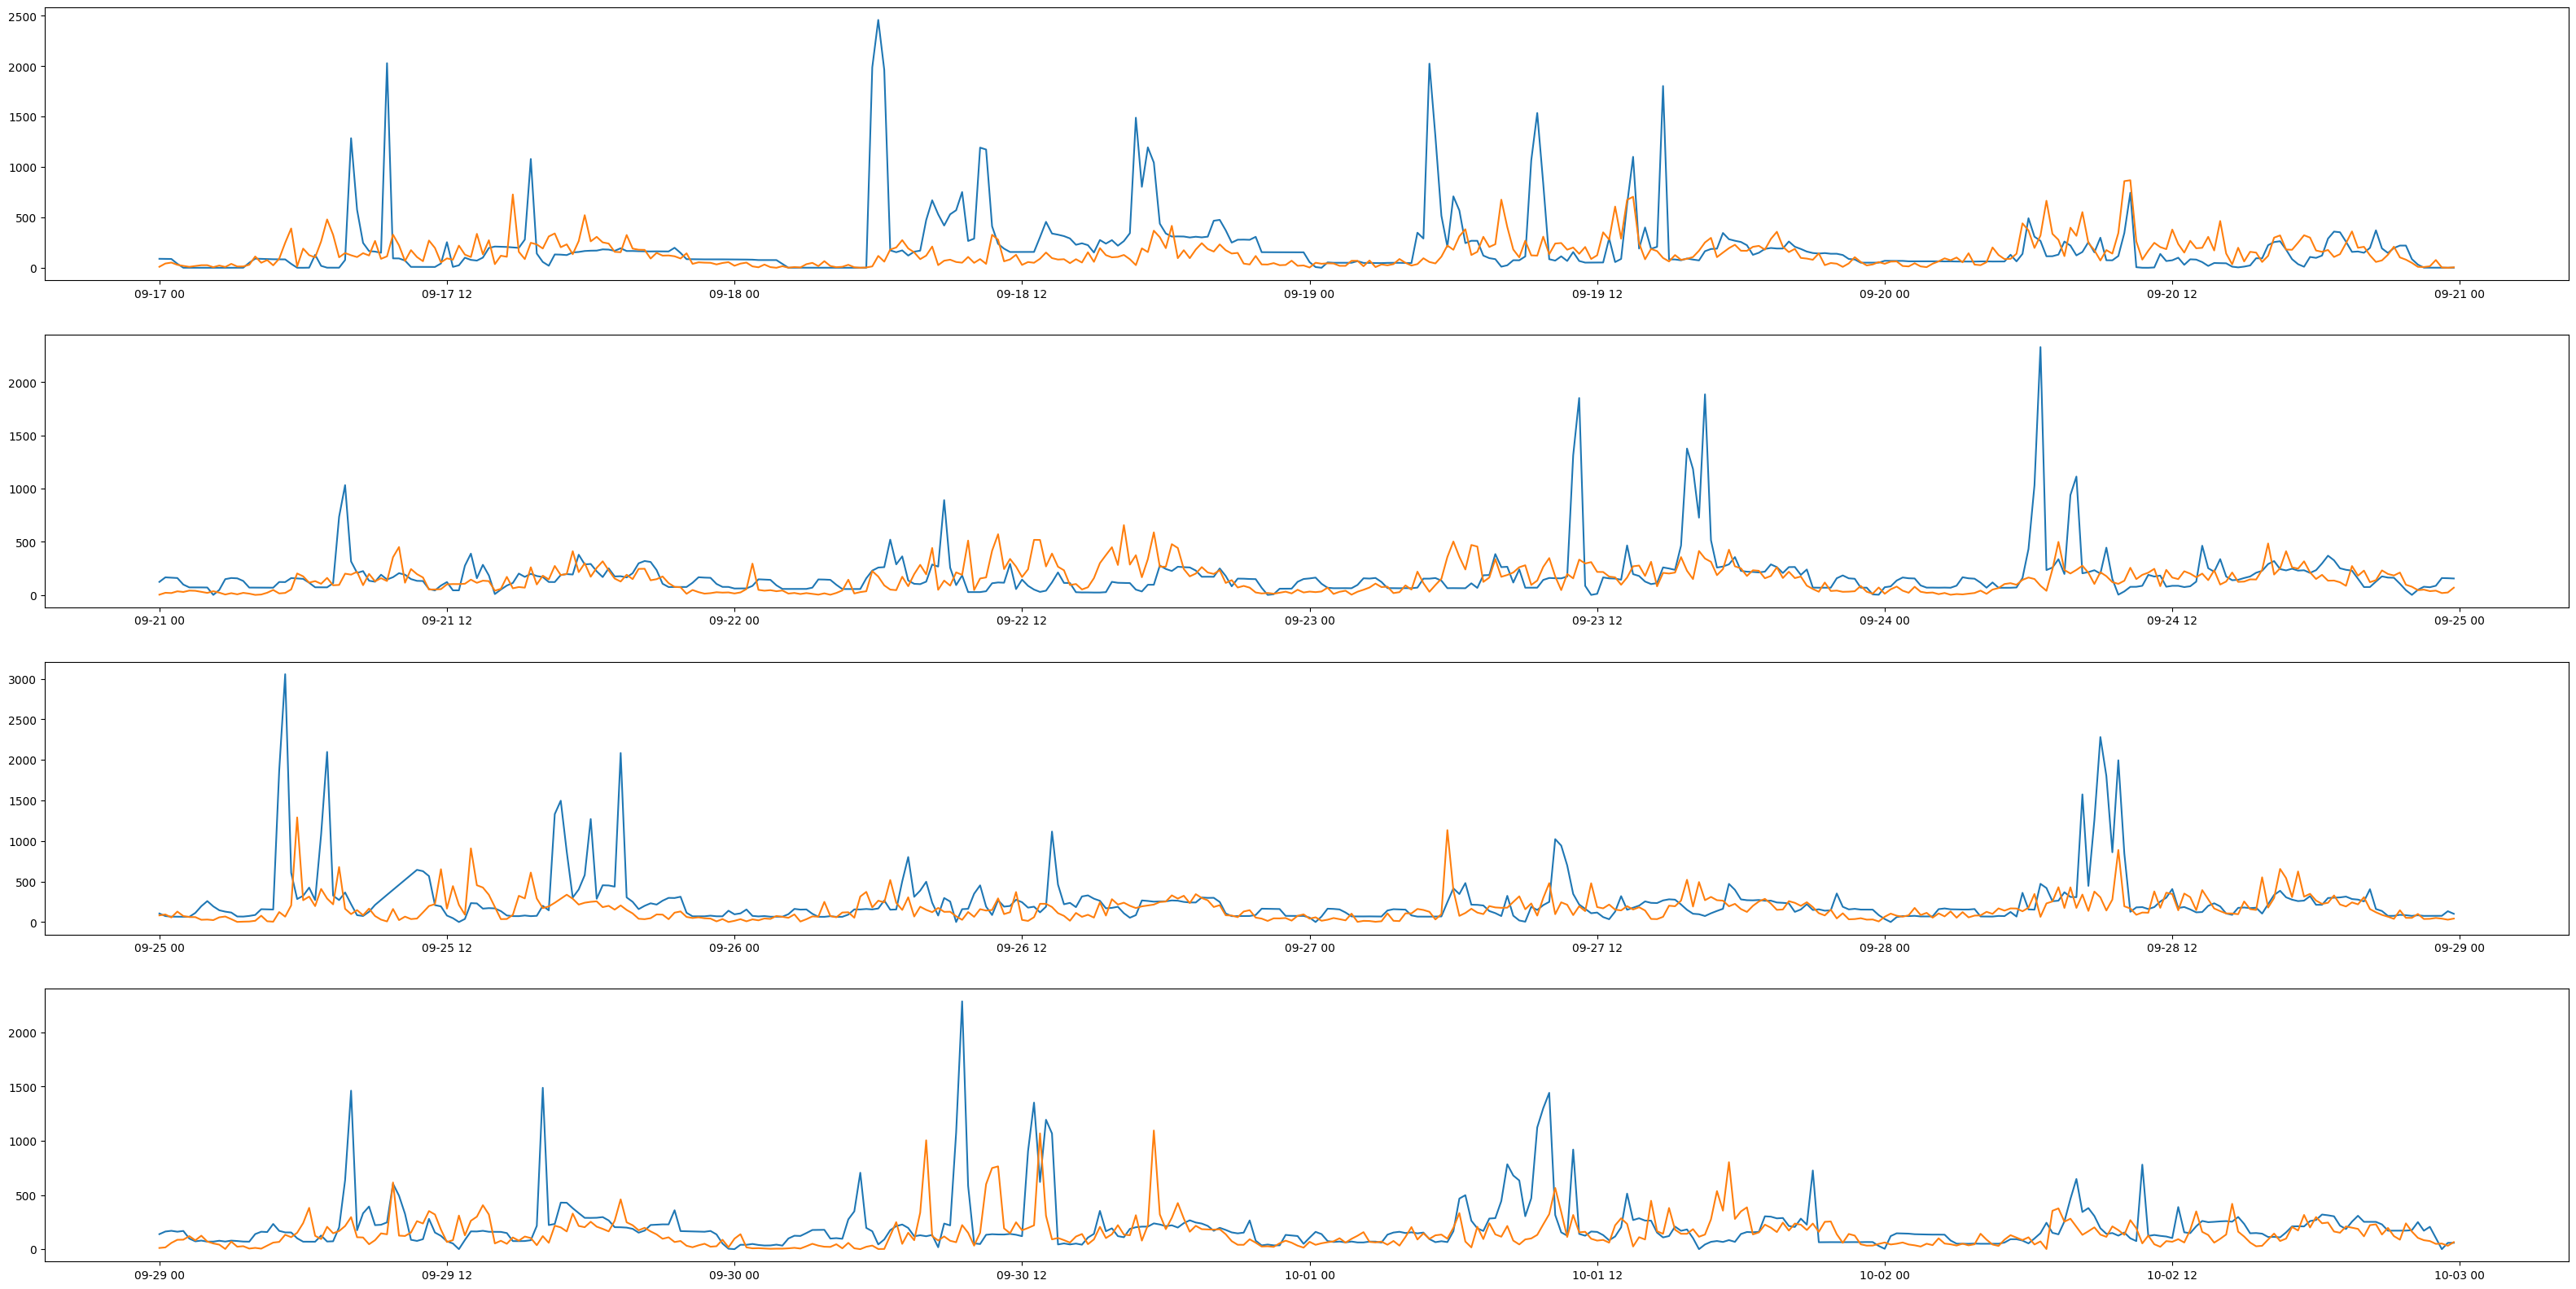

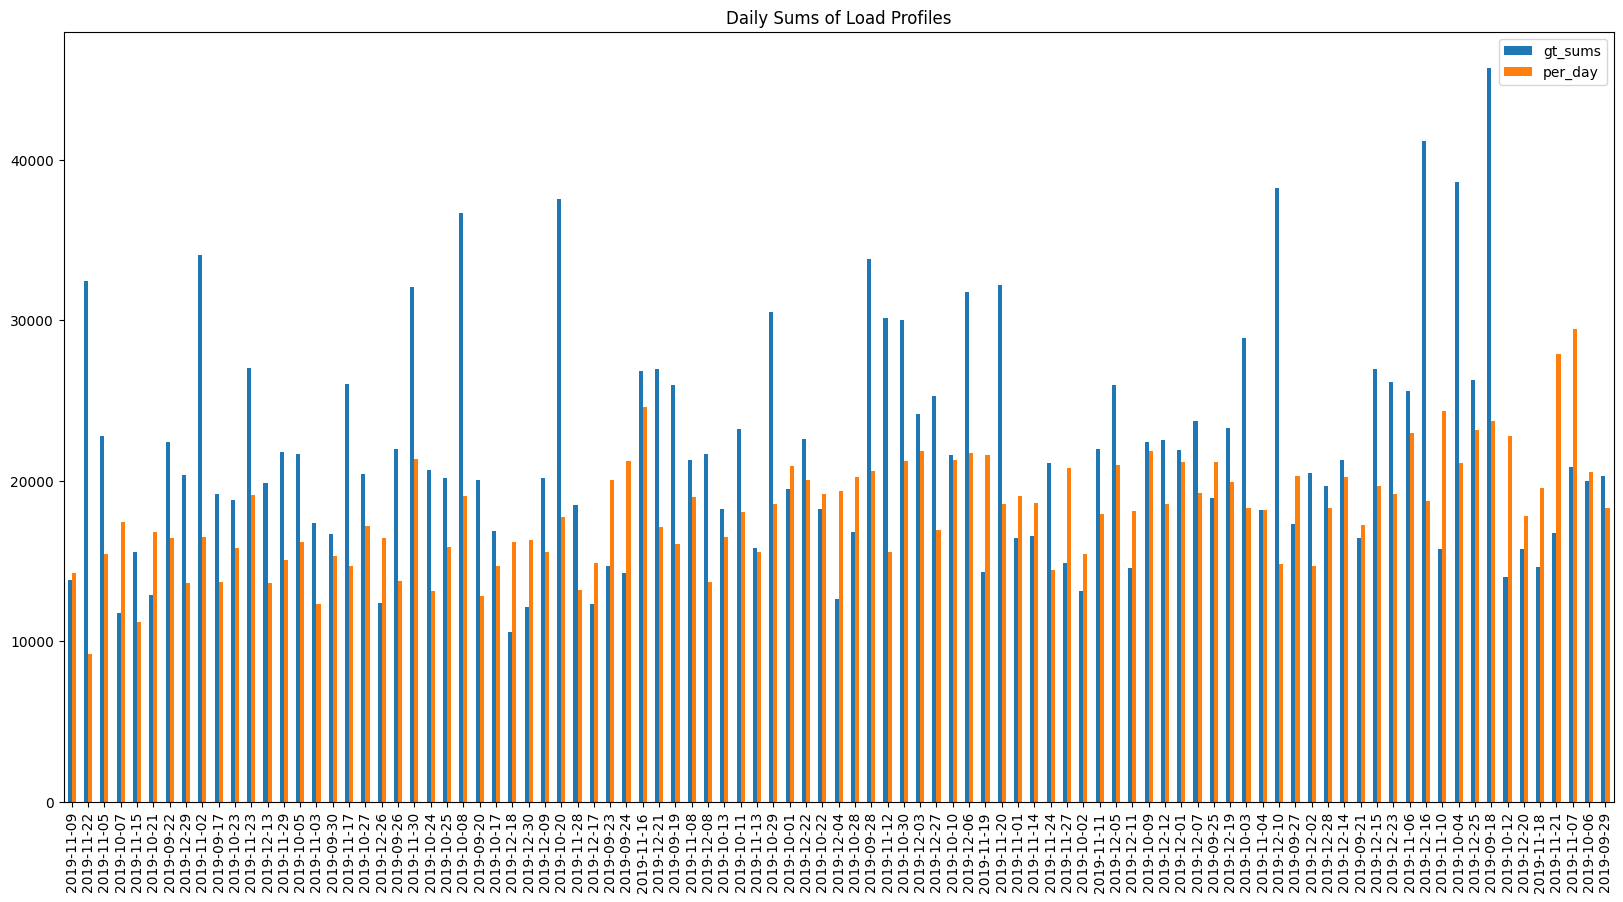

In [32]:
lets_train()

### Execution

In [ ]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
        'name': 'mae',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.01,0.1, 0.3]
}
}
}

sweep_id = wandb.sweep(sweep_config, project="XGBoost")
wandb.agent(sweep_id, lets_train)


### Grid Search

In [ ]:
wandb.init(
    project="XGBoost",
    )

wandb.config.update(config_features)
wandb.config.update(model_params)

config = wandb.config

#-----------------------#

df = df_clean.copy()
# Feature Engineering
#-----------------------#
if config.boxcox:
    df, config.lam = boxcox_transform(df)

# scaling the data

scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


# long to wide format, because we are doing daily predictions
df_pivot = timeseries_dataframe_pivot(df).dropna()
n_timesteps_per_output = df_pivot.shape[1]

# peaks
if config.peaks:
    df_peak_feature = timeseries_peak_feature_extractor(df)
    df_peak_feature_shifted = df_peak_feature.shift(1)
    df_pivot = pd.concat([df_pivot, df_peak_feature_shifted], axis=1).dropna()
    df_pivot.index = pd.to_datetime(df_pivot.index)


# past information
if config.cumsum:
    df = calc_rolling_sum_of_load(df, 7)
    df["load_of_last_day"] = df.iloc[:,:n_timesteps_per_output].sum(axis=1).shift(1)

lagged_days = config.lagged_days
if config.lagged_days > 0:
    for i in range(2,lagged_days+1):
        df = pd.concat([df_pivot, df_pivot.iloc[:,:n_timesteps_per_output].shift(i)],axis=1).dropna()

# holidays
if config.holidays:
    years = get_year_list(df_pivot)
    df_holidays_dummies = get_holidays(years, config.holidays_country)
    df_holidays = create_holiday_features(df_pivot, df_holidays_dummies)
    df_pivot = pd.concat([df_pivot, df_holidays], axis=1)

# datetime features
if config.datetime:
    df_pivot = create_datetime_features(df_pivot)

df_final = df_pivot.astype('float32').iloc[1:-1,:] # last row is nan

#-----------------------#

# Splits 

#-----------------------#
test_size = 0.2
train, test = train_test_split(df_final, test_size=test_size, shuffle=False)
test_idx = unpivot_timeseries_dataframe(test.iloc[:, :n_timesteps_per_output]).index

#features and target
X_train = train.iloc[:,n_timesteps_per_output:]
y_train = train.iloc[:,:n_timesteps_per_output]

X_test = test.iloc[:,n_timesteps_per_output:]
y_test = test.iloc[:,:n_timesteps_per_output]


scaler_features = MinMaxScaler()
X_train[X_train.columns] = scaler_features.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler_features.transform(X_test[X_test.columns])

#-----------------------#

In [13]:
### Random Search

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'learning_rate': [0.01,0.1, 0.3],
    'reg_lambda': [0, 0.1, 1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7]
}


xgb = XGBRegressor(**model_params)

# model evaluation

def dtw_metric(y_true, y_pred):
    distance, _ = fastdtw(y_true, y_pred)
    return distance

dtw_scorer = make_scorer(dtw_metric, greater_is_better=False)

random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=10, scoring=dtw_scorer, n_jobs=-1, cv=3, verbose=3, random_state=42)

random_search.fit(X_train, y_train)

print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[16:24:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

{'subsample': 0.7, 'reg_lambda': 0.1, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01}


In [15]:
model_1 = random_search.best_estimator_



### Benchmarks

In [ ]:
# create the persistence benchmarks
gt_long = df_first.loc[test_idx]
benchmark_day = gt_long.shift(n_timesteps_per_day).fillna(0).values.flatten() # previous day
benchmark_week = gt_long.shift(n_timesteps_per_day*7).fillna(0).values.flatten() # same day of previous week
gt = gt_long.values.flatten()